# Лабораторная работа №10: Генетический алгоритм
***
## Постановка задачи
Разработка приложения генерации учебного расписания. 
Задача: сгенерировать распитсание, которое содержит максимальное общее кол-во разных занятий.
Требования:
- 1) Расписание генерируется на N дней (размер учебной недели);
- 2) Заннятие в расписании должны быть равномерно распределены.

**Создание набора данных**

In [43]:
from dataclasses import dataclass as ds
import pandas as pd

@ds(init=False)
class l:
    name: str;
    cntl: int; # кол-во занятий подряд  

    def __init__(self, name: str, cntl: int) -> None:
        self.name = name
        self.cntl = cntl

ls = [
    l("Русский язык", 3),
    l("Математика", 3),
    l("Информатика", 3),
    l("Английский", 2),
    l("Физика", 2),
    l("Химия", 2),
    l("Литература", 2),
    l("История", 2),
    l("Физкультура", 1),
    l("Технология", 1),
    l("Музыка", 1),
    l("Биология", 1),
    l("География", 1),
    l("Рисование", 1),
    l("окно", 1)
]
EMPTY = 14

df = pd.DataFrame(columns=["name", "cntl"])
for item in ls:
    df.loc[len(df.index)] = [item.name, item.cntl]
df

,name,cntl
0,Русский язык,3
1,Математика,3
2,Информатика,3
3,Английский,2
4,Физика,2
5,Химия,2
6,Литература,2
7,История,2
8,Физкультура,1
9,Технология,1


## Проектирование вида хромосомы
 - Хромосома содержит перечень занятий
 - Размер хромосомы задается COUNT_LESSON_DAY x WEEK_SIZE
 - Каждый элемент такого списка будет являться ссылкой на некоторое занятий из набора данных

In [44]:
from typing import List
from pandas import DataFrame

""" Функция вывода хромосомы """
def get_chrom_list(df:DataFrame, data: List[List[int]]) -> List[List[str]]:
    return [[str(df.loc[i]["name"]) for i in item] for item in data]

## Функция генерации начальной популяции
Данная функция генерирует N хромосом особей начальной популции. Каждая хромосома представляет собой расписаний занятий, где ген есть ссылка на занятие. Решением будет хромосома, которое содержит максимальное число разных занятий, равномерно распределенных по дням.

Функция реализует самый простой способ генерации популяции -- (дробовик).

In [45]:
import numpy as np

""" time-table settings"""
ONE_LESSON_HOUR = 1
COUNT_LESSON_DAY = 4
WEEK_SIZE = 6

""" population settings"""
POPULATION_SIZE = 25
GENE_SIZE = COUNT_LESSON_DAY * WEEK_SIZE

""" Инициализируем список population. Пока кол-во популяций меньше заданного кол-ва, создаем хромосомы.
    Хромосома -- список размера COUNT_LESSON_DAY x WEEK_SIZE.
    Перебираем каждую гену в хромосоме, получаем случайное занятие из масива ls. Заполняем хромосому элементами 
    указанное количество раз для конкреттного элемента(занятия), при условии что оно умещается. 
"""
def population_init(ls: List[int], population_count: int, gene_size: int, empty, count_lesson_day) -> List[List[int]]:
    population: List[List[int]] = []
    cnt_les_day = count_lesson_day
    while len(population) < population_count:
        chrom: List[int] = [-1] * gene_size
        lesson = ls[empty]
        lscntl = 0
        for pos in range(gene_size):
            if (cnt_les_day == 0): cnt_les_day = count_lesson_day
            if (lscntl == 0): 
                rnd = np.random.choice(range(len(ls)))
                lesson = ls[rnd] 
                lscntl = df['cntl'].iloc[rnd]
            if (lscntl <= cnt_les_day):
                chrom[pos] = lesson
                lscntl -= 1
                cnt_les_day -= 1
            else:
                chrom[pos] = ls[empty]
                lscntl = 0
                cnt_les_day -= 1
        population.append(chrom)
    return population

def print_chrom(data: List[List[str]]):
    for row in data:
        print(row)

population = population_init(list(df.index.values), POPULATION_SIZE, GENE_SIZE, EMPTY, COUNT_LESSON_DAY)
print_chrom(get_chrom_list(df, population))

['Технология', 'География', 'География', 'окно', 'Музыка', 'Литература', 'Литература', 'Физкультура', 'Математика', 'Математика', 'Математика', 'окно', 'География', 'Химия', 'Химия', 'Биология', 'Рисование', 'История', 'История', 'Технология', 'Физкультура', 'География', 'окно', 'География']
['Информатика', 'Информатика', 'Информатика', 'окно', 'Информатика', 'Информатика', 'Информатика', 'окно', 'Литература', 'Литература', 'Химия', 'Химия', 'История', 'История', 'География', 'Музыка', 'Рисование', 'Литература', 'Литература', 'Музыка', 'Литература', 'Литература', 'Литература', 'Литература']
['Рисование', 'Информатика', 'Информатика', 'Информатика', 'Литература', 'Литература', 'История', 'История', 'Математика', 'Математика', 'Математика', 'Физкультура', 'окно', 'Технология', 'Физкультура', 'окно', 'Химия', 'Химия', 'Химия', 'Химия', 'Английский', 'Английский', 'Физкультура', 'окно']
['Информатика', 'Информатика', 'Информатика', 'окно', 'Химия', 'Химия', 'окно', 'окно', 'Русский язык', 

## Фитнес функция
Фитнес функция основана на методы подсчета частоты конкретного занятия в хромосоме и его скользящей.
Для оценки решения рассчитывается сумма отклонений частот занятий от их скользящих. Предполагается что чем ниже будет значение суммы отклонений (возвращаемое значение функции), тем оптимальнее решение, занятие более равномерно распределены по учебным дням.

    frequency       sma       dif
0    0.000000       NaN       NaN
1    0.000000       NaN       NaN
2    0.000000       NaN       NaN
3    0.000000  0.000000  0.000000
4    0.090909  0.022727  0.068182
5    0.090909  0.045455  0.045455
6    0.272727  0.113636  0.159091
7    0.090909  0.136364  0.045455
8    0.045455  0.125000  0.079545
9    0.136364  0.136364  0.000000
10   0.000000  0.068182  0.068182
11   0.000000  0.045455  0.045455
12   0.227273  0.090909  0.136364
13   0.045455  0.068182  0.022727


0.6704545454545453

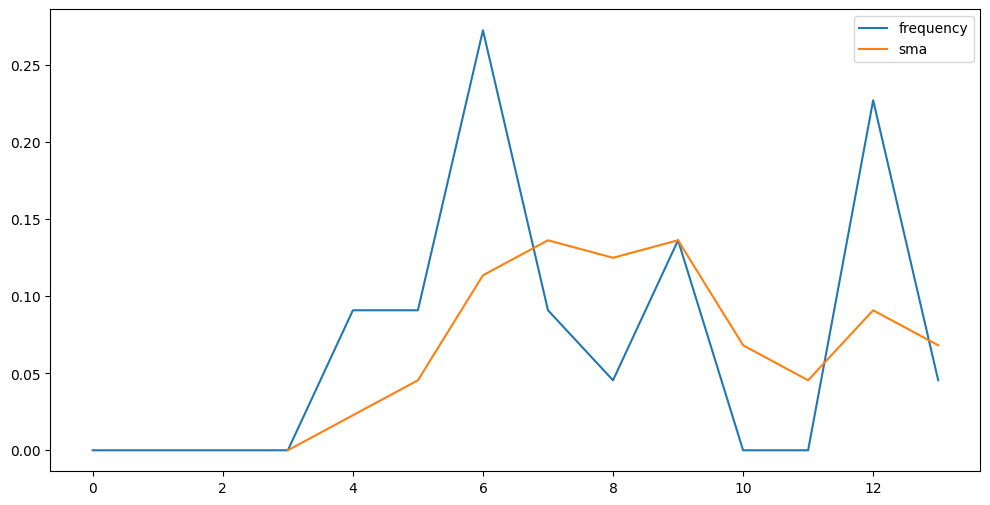

In [46]:
import matplotlib.pyplot as plt
def fitness(chrom: List[int], empty, count_lesson_day, debug = False) -> float:
    bag:List[int] = [0] * (df.shape[0] - 1)
    total_gen = 0
    for gen in chrom:
        if (gen == empty): continue
        total_gen += 1
        bag[gen] += 1
    for i in range(len(bag)):
        bag[i] /= total_gen
    bagdf = pd.DataFrame({'frequency':bag})
    bagdf['sma'] = bagdf['frequency'].rolling(window=count_lesson_day).mean()
    bagdf['dif'] = abs(bagdf['frequency'] - bagdf['sma'])

    if debug:
        print(bagdf)
        plt.figure(figsize=(12, 6))
        plt.plot(bagdf['frequency'], label="frequency")
        plt.plot(bagdf['sma'], label="sma")
        plt.legend()
        plt.show

    return bagdf['dif'].sum()

display(fitness([12, 6, 6, 9, 9, 6, 6, 12, 12, 8, 13, 14, 5, 5, 4, 4, 9, 6, 6, 14, 7, 7, 12, 12], EMPTY, COUNT_LESSON_DAY, True))

## Оператор кроссинговера
Данный оператор кроссинговеря представляет двухточечный оператор кроссинговера. Определяются возможные интервалы перестановки генов длиной COUNT_LESSON_DAY, один из которых будет случайно выбран. После чего гены входящие в интервал первой хромососы заменяются на соответствующие гены второй хромосомы.

In [47]:
def crossover(item1: List[int], item2:List[int], week_size, count_lesson_day) -> List[int]:
    points: List[list[int]] = []
    
    i = 0
    for j in range(week_size):
        span:List[int] = [-1, -1]
        span[0] = i
        i += count_lesson_day
        span[1] = i - 1
        points.append(span)

    rnd = np.random.choice(range(week_size))
    item1[points[rnd][0]:points[rnd][1]+1] = item2[points[rnd][0]:points[rnd][1]+1]
    return item1

print("Исходные:")
a = [0, 0, 0, 14, 10, 13, 14, 9, 12, 14, 9, 14, 1, 1, 1, 10, 1, 1, 1, 14, 13, 0, 0, 0]
b = [5, 5, 5, 5, 0, 0, 0, 12, 1, 1, 1, 11, 5, 5, 10, 14, 2, 2, 2, 12, 10, 10, 14, 14]
print_chrom(get_chrom_list(df, [a, b]))
print("Оператор кроссинговера:")
for i in range(4):
    print_chrom(get_chrom_list(df, [crossover(a.copy(),b.copy(), WEEK_SIZE, COUNT_LESSON_DAY)]))

Исходные:
['Русский язык', 'Русский язык', 'Русский язык', 'окно', 'Музыка', 'Рисование', 'окно', 'Технология', 'География', 'окно', 'Технология', 'окно', 'Математика', 'Математика', 'Математика', 'Музыка', 'Математика', 'Математика', 'Математика', 'окно', 'Рисование', 'Русский язык', 'Русский язык', 'Русский язык']
['Химия', 'Химия', 'Химия', 'Химия', 'Русский язык', 'Русский язык', 'Русский язык', 'География', 'Математика', 'Математика', 'Математика', 'Биология', 'Химия', 'Химия', 'Музыка', 'окно', 'Информатика', 'Информатика', 'Информатика', 'География', 'Музыка', 'Музыка', 'окно', 'окно']
Оператор кроссинговера:
['Русский язык', 'Русский язык', 'Русский язык', 'окно', 'Русский язык', 'Русский язык', 'Русский язык', 'География', 'География', 'окно', 'Технология', 'окно', 'Математика', 'Математика', 'Математика', 'Музыка', 'Математика', 'Математика', 'Математика', 'окно', 'Рисование', 'Русский язык', 'Русский язык', 'Русский язык']
['Русский язык', 'Русский язык', 'Русский язык', 'ок

## Оператор мутации
Данная реализация есть двухточечный оператор мутации. Случайным образом выбирается диапазон (т.е. учебный ден) ген для мутации, для которого будут случайно сгенерированы новыое занятия. Что позволяет выйти из локального оптимума.

In [48]:
def mutatuion(ls: List[int], population: List[List[int]], week_size, count_lesson_day, empty, proba = 1.0) -> List[List[int]]:
    points: List[List[int]] = []
    i = 0
    for j in range(week_size):
        span:List[int] = [-1, -1]
        span[0] = i
        i += count_lesson_day
        span[1] = i - 1
        points.append(span)

    for i in range(len(population)):
        if np.random.random(1)[0] > proba: continue
        nchrom: List[int] = [-1] * count_lesson_day
        
        lesson = ls[empty]
        lscntl = 0
        for pos in range(count_lesson_day):
            if (lscntl) == 0:
                rnd = np.random.choice(range(len(ls)))
                lesson = ls[rnd]
                lscntl = df['cntl'].iloc[rnd]
            if (lscntl <= count_lesson_day):
                nchrom[pos] = lesson
                lscntl -= 1
            else:
                nchrom[pos] = ls[empty]
                lscntl = 0

        rnd = np.random.choice(range(week_size))
        p1 = points[rnd][0]
        p2 = points[rnd][1] + 1

        population[i][points[rnd][0]:points[rnd][1]+1] = nchrom[0:len(nchrom)]
        
    return population
print_chrom(get_chrom_list(df, population[:1].copy()))
print_chrom(get_chrom_list(df,mutatuion(list(df.index.values), population[:1].copy(), WEEK_SIZE, COUNT_LESSON_DAY, EMPTY)))

['Технология', 'География', 'География', 'окно', 'Музыка', 'Литература', 'Литература', 'Физкультура', 'Математика', 'Математика', 'Математика', 'окно', 'География', 'Химия', 'Химия', 'Биология', 'Рисование', 'История', 'История', 'Технология', 'Физкультура', 'География', 'окно', 'География']
['Технология', 'География', 'География', 'окно', 'Музыка', 'Литература', 'Литература', 'Физкультура', 'Математика', 'Математика', 'Математика', 'окно', 'География', 'Химия', 'Химия', 'Биология', 'Музыка', 'Технология', 'История', 'История', 'Физкультура', 'География', 'окно', 'География']


## Генетический алгоритм
Для реализации ГА используется библиотека PyGAD (Python Generic Algorithm). Данная библиотека позволяет задать свои реализации функций-операторов ГА.
Библиотека позволяет задать параметры для генерации популяции, определения структуры хромосомы, определения типа и диапазона допустимых значений для генов, вероятность мутации и кроссинговера и т.д.

Чтобы использовать реализованные раннее функции, используются обертки (wrappers).

Результатом работы алгоритма является выбор оптимального расписания на учебую неделю с наименьшим значение фитнес-функции.

In [49]:
def fitness_func(ga_instanse, solution, solution_idx):
    return 1/(fitness(solution, EMPTY, COUNT_LESSON_DAY) + 0.000001)

def parent_selection_func(fitness, num_parents, ga_instance):
    fitness_sorted = sorted(range(len(fitness)), key=lambda k: fitness[k])
    fitness_sorted.reverse()

    parents = np.empty((num_parents, ga_instance.population.shape[1]))
    for parent_num in range(num_parents):
        parents[parent_num,:] = ga_instance.population[fitness_sorted[parent_num],:].copy()
    return parents, np.array(fitness_sorted[:num_parents])

def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        if np.random.random(1)[0] > ga_instance.crossover_probability: offspring.append(parent1)
        else:
            result = crossover(parent1, parent2, WEEK_SIZE, COUNT_LESSON_DAY)
            offspring.append(result)
        idx += 1
    return np.array(offspring)

def mutation_func(offspring, ga_instance):
    return mutatuion(list(df.index.values), offspring, WEEK_SIZE, COUNT_LESSON_DAY, EMPTY, ga_instance.mutation_probability)


c:\Users\Ilfe\MaiProject\mai4\.venv\Lib\site-packages\pygad\pygad.py:1136: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
c:\Users\Ilfe\MaiProject\mai4\.venv\Lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


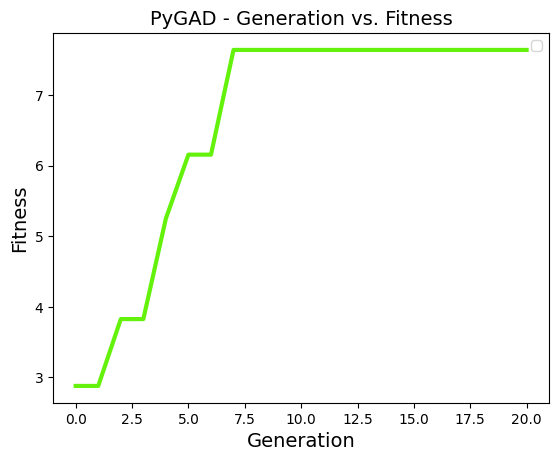

(array([13, 11,  7,  7, 14,  8,  0,  0,  3,  3,  6,  6, 14,  2,  2,  2,  5,
         5, 12,  8, 10,  4,  4, 14]),
 7.6363053227593545,
 0)

Рисование, Биология, История, История, 
окно, Физкультура, Русский язык, Русский язык, 
Английский, Английский, Литература, Литература, 
окно, Информатика, Информатика, Информатика, 
Химия, Химия, География, Физкультура, 
Музыка, Физика, Физика, окно, 
    frequency       sma       dif
0    0.095238       NaN       NaN
1    0.000000       NaN       NaN
2    0.142857       NaN       NaN
3    0.095238  0.083333  0.011905
4    0.095238  0.083333  0.011905
5    0.095238  0.107143  0.011905
6    0.095238  0.095238  0.000000
7    0.095238  0.095238  0.000000
8    0.095238  0.095238  0.000000
9    0.000000  0.071429  0.071429
10   0.047619  0.059524  0.011905
11   0.047619  0.047619  0.000000
12   0.047619  0.035714  0.011905
13   0.047619  0.047619  0.000000
0.13095238095238093


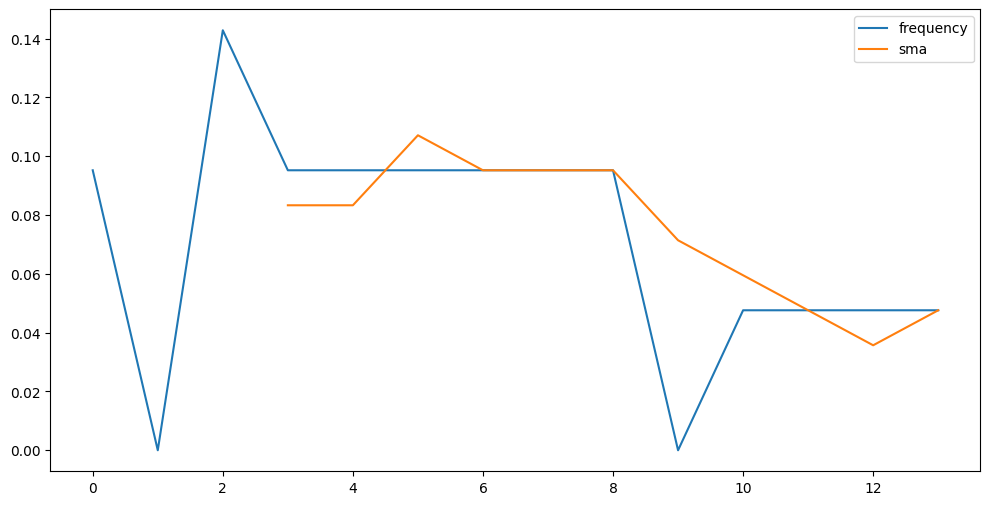

In [50]:
import pygad as pga

ga = pga.GA(
    gene_type=int,
    num_generations=20,
    initial_population=population,
    num_parents_mating=int(POPULATION_SIZE * 0.3),
    fitness_func=fitness_func,
    parent_selection_type=parent_selection_func,
    crossover_type=crossover_func,
    crossover_probability=1.0,
    mutation_type=mutation_func,
    mutation_probability=0.3,
    save_best_solutions=True
)
ga.run()
ga.plot_fitness()
display(ga.best_solution())

timetable = list(ga.best_solution()[0])
ans = get_chrom_list(df, [timetable])

ls_in_day = ""
count_ls = COUNT_LESSON_DAY
for elem in ans[0]:
    if (count_ls == 0):
        print(ls_in_day) 
        count_ls = COUNT_LESSON_DAY
        ls_in_day = ""
    ls_in_day += elem
    ls_in_day += ", " 
    count_ls -= 1
print(ls_in_day)
print(fitness(timetable, EMPTY, COUNT_LESSON_DAY, True))